# 德国信用卡数据与分析 — YTP

In [190]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from imblearn.over_sampling import SMOTE

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


### 复制原文件建立新数据处理文件
帮助我们确保有迹可循，分析过程中不会直接影响之前的数据库（损坏或者更改）
可以在数据处理期间用备份的数据库进行一些修改改动等

In [2]:
# 读取源Excel文件
source_file_path = 'resources/German_credit.xlsx' 
df = pd.read_excel(source_file_path)
# 创建一个新的Excel文件并将数据写入其中
new_file_path = 'resources/German_credit_NEW.xlsx'
df.to_excel(new_file_path, index=False)
print(f'Data successfully copied to {new_file_path}')
# data现在是我们用来分析的源数据附件
data = pd.read_excel(new_file_path)

Data successfully copied to resources/German_credit_NEW.xlsx


## 特征变量筛检（这里在分箱前）
因为项目已经精简了数据库（预处理，分箱和编码都完成了），所以在此之上我选择了先进行变量分析去模拟下整个过程。目标是找到前几个比较有影响力的变量，后续再进行进一步分箱和模型建立。
以下步骤是先画图去了解数据变量内容，和形式还有和目标变量的关系等。这样我们后面进行主要变量的选择会更明确，模型会更贴切我们的问题和目标。


In [3]:
# # 查看数据概况
# print(df.info())
# print(df.describe())

In [4]:
# # 绘制数据直方图
# def plot_histograms(df, columns):
#     df[columns].hist(bins=20, figsize=(20, 15))
#     plt.suptitle('Histogram of each class', fontsize= 20, fontweight='bold')
#     plt.show()
# plot_histograms(df, df.columns[:-1])


In [5]:
# # 绘制数据箱线图
# def plot_boxplots(df, columns):
#     df[columns].plot(kind='box', subplots=True, layout=(5, 5), sharex=False, sharey=False,figsize=(20, 15))
#     plt.suptitle('Boxplot of features', fontsize= 20, fontweight='bold')
#     plt.show()
# plot_boxplots(df, df.columns[:-1])


这里我在数据库本有的变量中进行了对目标变量的影响进行比较，第一步是热图第二步是随机森林相关图。然后每个结果排序中拿前十名最后进行汇总。

In [124]:
# 选择的影响力大的变量数量，前十名----------------------
numVar = 10

# 绘制数据相关性热图
def plot_correlation_heatmap(df1):
    plt.figure(figsize=(15, 10))
    corr_matrix = df1.corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap= 'coolwarm', cbar=True, square=True)
    plt.title('Correlation Heatmap', fontsize= 20, fontweight='bold')
    plt.show()
# plot_correlation_heatmap(df)
# 找到对target最有影响力的变量，依次排名，选numVar个较有影响力的
def find_top_correlated_features(df2, target1, n):
    corr_matrix = df2.corr()
    target_cor = corr_matrix[target1].abs().sort_values(ascending=False)
    top_features = target_cor.index[1:n+1]  # 排除掉target本身
    return top_features, target_cor

selected_features_CHMap, target_corr = find_top_correlated_features(df, 'target', numVar)
print(f'Top correlated features with target: {selected_features_CHMap.tolist()}')

Top correlated features with target: ['Account Balance', 'Payment Status of Previous Credit', 'Duration of Credit (month)', 'Value Savings/Stocks', 'Credit Amount', 'Most valuable available asset', 'Length of current employment', 'Concurrent Credits', 'Age (years)', 'Sex & Marital Status']


In [122]:
# 绘制随机森林模型相关图
# 特征选择和目标变量
features = data.columns[data.columns != 'target'] 
target = 'target'
# 分割数据集
X = data[features]
y = data[target]
# 构建随机森林模型以评估特征重要性
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
# 获取特征重要性
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# # 可视化特征重要性
# plt.figure(figsize=(10, 8))
# plt.barh(feature_importances['Feature'], feature_importances['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()
# 筛选重要性较高的变量，依次排名，选numVar个较有影响力的
selected_features_rf = feature_importances.nlargest(numVar, 'Importance')['Feature']
print(f'Top correlated features with target: {selected_features_rf.tolist()}')

Top correlated features with target: ['Credit Amount', 'Account Balance', 'Age (years)', 'Duration of Credit (month)', 'Purpose', 'Payment Status of Previous Credit', 'Length of current employment', 'Value Savings/Stocks', 'Most valuable available asset', 'Instalment per cent']


In [125]:
# 采用了合并并去重采用了两列排名靠前的变量
# 合并并去重
combined_features = selected_features_rf.tolist() + selected_features_CHMap.tolist()
unique_features_set = set(combined_features)
selected_features_final = list(unique_features_set)
print(selected_features_final)

['Account Balance', 'Purpose', 'Sex & Marital Status', 'Length of current employment', 'Most valuable available asset', 'Instalment per cent', 'Payment Status of Previous Credit', 'Concurrent Credits', 'Credit Amount', 'Duration of Credit (month)', 'Value Savings/Stocks', 'Age (years)']


## 数据分箱 （Binning）

通过上一步数据筛选，我们会最终选择几个对目标变量有影响力的变量进行分箱，大大帮助后期模型的建立的准确性

binning（data, column, n_bins, strategy）:

根据所选择的变量，分箱数，策略进行数据分箱
- **n_bins**: 箱子数量

- **strategy**: 
    - 'uniform': 每个箱宽度相等
    - 'quantile': 按照等频分箱，每个箱中的数据点数量相同
    - 'kmeans'：使用K-means分箱，根据数据点分布自动确定箱。更智能
-----------------------------------------------------------
calculate_woe_iv（data, column, target）:

通过计算每个分箱中好样本和坏样本的比例，计算出每个分箱的WOE值，并根据这些WOE值计算总体的IV值。WOE值用于将分类变量转化为连续变量，而IV值用于衡量每个特征的预测能力。这样，你可以筛选出最有预测能力的特征，并将它们用于模型构建。

In [155]:
# 分箱函数
def binning(bdata, bcolumn, n_bins, strategy='uniform'): 
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    bdata[bcolumn + '_binned'] = est.fit_transform(bdata[[bcolumn]])
    return bdata, est

# 计算WOE, IV函数
def calculate_woe_iv(cdata, ccolumn, ctarget):
    woe_dict = {}
    iv = 0
    total_good = sum(cdata[ctarget] == 0)
    total_bad = sum(cdata[ctarget] == 1)
    
    for bin in sorted(cdata[ccolumn].unique()):
        bin_data = cdata[cdata[ccolumn] == bin]
        good = sum(bin_data[ctarget] == 0)
        bad = sum(bin_data[ctarget] == 1)
        good_dist = good / total_good if total_good != 0 else 0
        bad_dist = bad / total_bad if total_bad != 0 else 0
        
        # 处理可能的零或NaN情况
        if good_dist == 0:
            good_dist = 1e-10
        if bad_dist == 0:
            bad_dist = 1e-10
        
        woe = np.log(good_dist / bad_dist)
        woe_dict[bin] = woe
        iv += (good_dist - bad_dist) * woe
    
    return woe_dict, iv


In [173]:
# 特征选择和目标变量, 我们已经选择好了几个对目标值有影响力的变量所以只用表明目标是哪个，在这里就是“target”
target_column = 'target'

# 寻找最优分箱数量 和 WOE & IV 计算
def select_best_binning(df, selected_features, target_column):
    results = {}
    woe_iv_values = {}
    df_copies = {}  # 存储每次分箱后的数据框
    for n_bins in range(2, 61):
        df_copy = df.copy()
        woe_iv_values[n_bins] = {}
        for column in selected_features:
            df_copy, binning_estimator = binning(df_copy, column, n_bins)
            woe_dict, iv = calculate_woe_iv(df_copy, column + '_binned', target_column)
            df_copy[column + '_woe'] = df_copy[column + '_binned'].map(woe_dict)
            woe_iv_values[n_bins][column] = {'woe': woe_dict, 'iv': iv}
        
        # 模型训练和验证，用了逻辑回归模型
        X = df_copy[[col + '_woe' for col in selected_features]]
        y = df_copy[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        results[n_bins] = auc
        
        df_copies[n_bins] = df_copy
    
    # 找到AUC最高的分箱方法,AUC代表Area Under the ROC Curve,用来评估分类模型性能的一个常用指标
    best_n_bins = max(results, key=results.get)
    best_df = df_copies[best_n_bins]
    
    print("AUC scores for different binning numbers:", results)
    return best_n_bins, results[best_n_bins], woe_iv_values[best_n_bins], best_df

# 寻找和打印最后的选择数据,data为后面建立模型的数据库
best_bins, best_auc, best_woe_iv_values, data  = select_best_binning(data, selected_features_final, target_column)

# 打印结果
print("\n***************************\n"+f"Best binning number: {best_bins} with AUC: {best_auc}"+'\n***************************\n')

# for column, values in best_woe_iv_values.items():
#     print(f"Feature: {column}")
#     print(f"WOE values: {values['woe']}")
#     print(f"IV value: {values['iv']}")
#     print("---------------------------")


AUC scores for different binning numbers: {2: 0.7240476190476188, 3: 0.7287499999999999, 4: 0.7429761904761906, 5: 0.7611904761904762, 6: 0.7613095238095238, 7: 0.7616666666666666, 8: 0.758095238095238, 9: 0.7592857142857143, 10: 0.7739285714285714, 11: 0.7646428571428571, 12: 0.7707142857142858, 13: 0.7597619047619047, 14: 0.7673809523809524, 15: 0.784047619047619, 16: 0.7708333333333334, 17: 0.7798809523809525, 18: 0.7736904761904762, 19: 0.7792857142857142, 20: 0.7813095238095238, 21: 0.785952380952381, 22: 0.7790476190476191, 23: 0.7825, 24: 0.7846428571428571, 25: 0.7828571428571428, 26: 0.7858333333333333, 27: 0.7838095238095238, 28: 0.7804761904761904, 29: 0.7822619047619047, 30: 0.7852380952380952, 31: 0.788452380952381, 32: 0.7841666666666666, 33: 0.7892857142857143, 34: 0.8053571428571429, 35: 0.7942857142857143, 36: 0.8059523809523809, 37: 0.794047619047619, 38: 0.8029761904761905, 39: 0.8014285714285715, 40: 0.8076190476190477, 41: 0.7867857142857143, 42: 0.7807142857142858

这里可以看到结果显示分箱数为54的时候，AUC值是最高的，所以我选择采用这个分箱数量并计算WOE和IV值用于后面的模型训练。

## 模型构造与验证

In [170]:
# 最终变量选择，选择IV值最高的前几个,但经过测试，发现按照我的步骤，11个变量会是最高准确率
NumFea = 11
iv_values_sorted = sorted(best_woe_iv_values.items(), key=lambda item: item[1]['iv'], reverse=True)
top_iv_features = iv_values_sorted[:NumFea]

# 打印出来为了更方便追踪数据
print("\nSelected top IV features for modeling:")
for feature, values in top_iv_features:
    print(f" {feature}, IV value: {values['iv']}")
# 提取特征名称列表
top_iv_feature_names = [item[0] for item in top_iv_features]
print("\nTop IV feature Selected Names:", top_iv_feature_names)


Selected top IV features for modeling:
 Duration of Credit (month), IV value: 1.0495353305806965
 Credit Amount, IV value: 1.0314557255592238
 Account Balance, IV value: 0.6660115033513336
 Age (years), IV value: 0.6129095040344794
 Payment Status of Previous Credit, IV value: 0.2932335473908263
 Value Savings/Stocks, IV value: 0.19600955690422672
 Purpose, IV value: 0.16919506567307832
 Most valuable available asset, IV value: 0.11263826240979674
 Length of current employment, IV value: 0.086433631026641
 Concurrent Credits, IV value: 0.057614541955647885
 Sex & Marital Status, IV value: 0.04467067763379073

Top IV feature Selected Names: ['Duration of Credit (month)', 'Credit Amount', 'Account Balance', 'Age (years)', 'Payment Status of Previous Credit', 'Value Savings/Stocks', 'Purpose', 'Most valuable available asset', 'Length of current employment', 'Concurrent Credits', 'Sex & Marital Status']


 **train_test_split():**
  - arrays：需要分割的输入数据。通常是特征矩阵和目标向量。
  - test_size：测试集所占的比例，可以是浮点数（表示比例）或整数（表示测试集样本数）。默认值为0.25。
  - train_size：训练集所占的比例，可以是浮点数（表示比例）或整数（表示训练集样本数）。如果未指定，默认值为 1 - test_size。
  - random_state：随机种子，确保每次运行都得到相同的分割结果。可以是整数或 None。
  - shuffle：是否在分割之前对数据进行打乱。默认值为 True。
  - stratify：按某个变量分层抽样，确保分层变量在训练集和测试集中有相同的分布。通常用于分类任务。 

### 分割数据为训练集和测试机
我选择的比例为 train : test = 6 : 4
当然这个数值也会影响到最后的结果，这个比例对我的步骤来讲会产生较高的准确率。但是如果将训练集进一步减少导致测试集数量大于它的话，我担心模型最后的局限性所以通常训练集是占比较大的。

In [178]:
# 分割数据集为训练集和测试集在我选择的变量中
X = data[[col + '_woe' for col in top_iv_feature_names]]
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# print('y_train:', y_train)
# print('y_test:', y_test)

### 主流模型基础运用

这里主要是演示各个主流模型基础运用，我这里直接运用模型并直接找出准确率最高的模型去更直观的比较。当然也可以一个个去尝试并记录结果。
这一步没有添加任何额外的步骤去比较，只是简单的用模型去训练并预测，然后最后准确率对比选择最好的。

In [ ]:
# 定义几个常用的模型,可以自行选择尝试---------------
# 建立逻辑回归模型 (Logistic Regression)
model_LR = LogisticRegression(max_iter=10000, C=1.0, penalty='l2', solver='lbfgs')

# 建立决策树模型 (Decision Tree)
model_DT = DecisionTreeClassifier(random_state=42)

# 建立随机森林模型 (Random Forest)
model_RF = RandomForestClassifier(random_state=42)

# 建立梯度提升机模型 (Gradient Boosting Machine, GBM)
model_GBM = GradientBoostingClassifier(random_state=42)

# 建立支持向量机模型 (Support Vector Machine, SVM)
model_SVC = SVC(probability=True, random_state=42)

In [180]:
# 对数据进行标准化处理,标准化是指将数据调整到均值为0、标准差为1的分布。
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 定义模型
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, C=1.0, penalty='l2', solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

# 存储结果的字典
results = {}
# 训练和评估每个模型
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

# 找出准确率最高的模型
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_model_results = results[best_model_name]

# 输出最佳模型的结果
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_model_results['accuracy']}")
print(f"AUC: {best_model_results['auc']}")
print("Confusion Matrix:")
print(best_model_results['confusion_matrix'])
print("Classification Report:")
print(best_model_results['classification_report'])

#
# # 这是最基础的一个模型下的运算代码, 如果想要一个个去查验,可以直接用下面注释代码
# # 记得model后缀加上对应的代码!!!
# # 在训练集上训练模型
# model.fit(X_train, y_train)
# # 在测试集上进行预测
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[:, 1]
# 
# # 评估模型性能
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
# print(f'AUC: {roc_auc_score(y_test, y_pred_proba)}')
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

Best Model: Logistic Regression
Accuracy: 0.8075
AUC: 0.8439583333333334
Confusion Matrix:
[[248  32]
 [ 45  75]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       280
           1       0.70      0.62      0.66       120

    accuracy                           0.81       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.80      0.81      0.80       400


### 提升模型准确率

通常，为了提高准确率，在模型建立和训练时应加上额外的步骤，比如交叉评估等。
我这里运用了集成学习，交叉验证，其实就是上一段代码的提升。还是对主流模型进行评估比较然后选择最好的模型，这样会更严谨而且我们能看到模型的数据。

In [185]:
# 集成学习 - 投票分类器
voting_clf = VotingClassifier(
    estimators=[
        ('lr', model_LR),
        ('dt', model_DT),
        ('rf', model_RF),
        ('gbm', model_GBM),
        ('svc', model_SVC)
    ],
    voting='soft'
)

# 交叉验证评估模型性能
models = {
    'Logistic Regression': model_LR,
    'Decision Tree': model_DT,
    'Random Forest': model_RF,
    'Gradient Boosting': model_GBM,
    'Support Vector Machine': model_SVC,
    'Voting Classifier': voting_clf
}

# 存储结果的字典
results = {}

# 训练和评估每个模型
for name, model in models.items():
    # 使用交叉验证评估模型性能
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # 在训练集上训练模型
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

# 找出准确率最高的模型
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_model_results = results[best_model_name]

# 输出最佳模型的结果
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_model_results['accuracy']:.4f}")
print(f"AUC: {best_model_results['auc']:.4f}")
print("Confusion Matrix:")
print(best_model_results['confusion_matrix'])
print("Classification Report:")
print(best_model_results['classification_report'])


Logistic Regression Cross-validated accuracy: 0.7917 ± 0.0376
Decision Tree Cross-validated accuracy: 0.6900 ± 0.0318
Random Forest Cross-validated accuracy: 0.7533 ± 0.0476
Gradient Boosting Cross-validated accuracy: 0.7500 ± 0.0253
Support Vector Machine Cross-validated accuracy: 0.7650 ± 0.0403
Voting Classifier Cross-validated accuracy: 0.7683 ± 0.0232

Best Model: Logistic Regression
Accuracy: 0.8075
AUC: 0.8440
Confusion Matrix:
[[248  32]
 [ 45  75]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       280
           1       0.70      0.62      0.66       120

    accuracy                           0.81       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.80      0.81      0.80       400


由此可见，两次结果都是显示逻辑回归模型为最好的，结果也是一样的因为训练集和测试集，还有其它参数都没有变化。

### 模型堆叠 （Stacking）
我们可以通过再一次的训练集成学习模型进一步提高模型的性能。
即将不同模型的预测结果作为新的特征输入到一个最终模型中进行训练。


#### 第二次运用逻辑回归模型去训练

In [189]:
# 使用最佳模型的预测结果作为新的特征
X_train_meta = np.column_stack([model.predict_proba(X_train)[:, 1] for model in models.values()])
X_test_meta = np.column_stack([model.predict_proba(X_test)[:, 1] for model in models.values()])

# 使用新的特征训练逻辑回归模型
meta_model_LR = LogisticRegression(max_iter=10000, C=1.0, penalty='l2', solver='lbfgs')
meta_model_LR.fit(X_train_meta, y_train)

# 进行预测
y_pred_meta = meta_model_LR.predict(X_test_meta)
y_pred_proba_meta = meta_model_LR.predict_proba(X_test_meta)[:, 1]

# 评估最终逻辑回归模型性能
accuracy_meta = accuracy_score(y_test, y_pred_meta)
auc_meta = roc_auc_score(y_test, y_pred_proba_meta)

# 输出最终逻辑回归模型的结果
print("\nFinal Meta Logistic Regression Model")
print(f"Accuracy: {accuracy_meta:.4f}")
print(f"AUC: {auc_meta:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_meta))
print("Classification Report:")
print(classification_report(y_test, y_pred_meta))


Final Meta Logistic Regression Model
Accuracy: 0.6725
AUC: 0.7781
Confusion Matrix:
[[214  66]
 [ 65  55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       280
           1       0.45      0.46      0.46       120

    accuracy                           0.67       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.67      0.67      0.67       400


但是我们可以看到这么做并不会在这里提高模型的准确率，所以说明可能是数据大小还有之前步骤导致的。
还有另外一种办法是套用 StackingClassifier,这个是更加正式的堆叠方法，将他添加到我们之前的模型里，这样这个模型中还会包含一个堆叠模型去进行训练
- StackingClassifier是Scikit-Learn中实现堆叠模型的一个类。它使用多个基础模型（第一层模型）来生成预测，然后将这些预测作为输入特征，传递给一个最终的模型（第二层模型）进行最终预测。

In [193]:

# 定义基础模型的元组
estimators = [
    ('lr', model_LR),
    ('dt', model_DT),
    ('rf', model_RF),
    ('gbm', model_GBM),
    ('svc', model_SVC)
]

# 定义堆叠分类器，最终模型选择了逻辑回归模型
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=10000)
)

# 交叉验证评估模型性能
models = {
    'Logistic Regression': model_LR,
    'Decision Tree': model_DT,
    'Random Forest': model_RF,
    'Gradient Boosting': model_GBM,
    'Support Vector Machine': model_SVC,
    'Stacking Classifier': stacking_clf
}

# 存储结果的字典
results = {}

# 训练和评估每个模型
for name, model in models.items():
    # 使用交叉验证评估模型性能
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # 在训练集上训练模型
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

# 找出准确率最高的模型
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_model_results = results[best_model_name]

# 输出最佳模型的结果
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_model_results['accuracy']:.4f}")
print(f"AUC: {best_model_results['auc']:.4f}")
print("Confusion Matrix:")
print(best_model_results['confusion_matrix'])
print("Classification Report:")
print(best_model_results['classification_report'])


Logistic Regression Cross-validated accuracy: 0.7917 ± 0.0376
Decision Tree Cross-validated accuracy: 0.6900 ± 0.0318
Random Forest Cross-validated accuracy: 0.7533 ± 0.0476
Gradient Boosting Cross-validated accuracy: 0.7500 ± 0.0253
Support Vector Machine Cross-validated accuracy: 0.7650 ± 0.0403
Stacking Classifier Cross-validated accuracy: 0.7850 ± 0.0305

Best Model: Stacking Classifier
Accuracy: 0.8100
AUC: 0.8420
Confusion Matrix:
[[253  27]
 [ 49  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       280
           1       0.72      0.59      0.65       120

    accuracy                           0.81       400
   macro avg       0.78      0.75      0.76       400
weighted avg       0.80      0.81      0.80       400


我们可以明显看到准确率有提升，但是并不明显。并且相比之前逻辑回归模型，坏客户（1）的recall率还是下降了点，这也并不是我们想看到的。
这一方法在本数据库中只有1k个数据可能提升不大，但是的确是个很好用的办法。

## 评分卡和模型建立

最后，在我们模型建立并且训练完成以后，我们可以开始构建评分卡和最后的评分模型建立。经过上一步的模型验证，我们确认了最后会运用逻辑回归模型去建立我们的评分系统。

In [195]:
# 构建评分卡
def compute_scorecard(model, scaler, X, base_score=600, pdo=50):
    # 获取模型系数和特征
    coef = model.coef_[0] # coef_ is only available when using a linear kernel
    intercept = model.intercept_[0]
    features = X.columns

    # 计算B和A参数
    B = pdo / np.log(2)
    A = base_score - B * intercept

    # 创建评分卡
    scorecard = {}
    for feature, weight in zip(features, coef):
        feature_mean = scaler.mean_[list(features).index(feature)]
        feature_std = scaler.scale_[list(features).index(feature)]
        scorecard[feature] = {
            'weight': weight,
            'mean': feature_mean,
            'std': feature_std,
            'score': -weight * B / feature_std
        }
    return A, B, scorecard

# 计算评分卡
A, B, scorecard = compute_scorecard(model_LR, scaler, pd.DataFrame(X_train,columns=[col + '_woe' for col in top_iv_feature_names]))

# 打印评分卡
print(f"Base Score (A): {A:.2f}")
print(f"Factor (B): {B:.2f}")
print("Scorecard:")
for feature, params in scorecard.items():
    print(f"{feature}: weight={params['weight']:.4f}, mean={params['mean']:.4f}, std={params['std']:.4f}, score={params['score']:.4f}")

# 使用评分卡计算分数
def calculate_score(X, A, B, scorecard):
    scores = np.full(X.shape[0], A)
    feature_scores = pd.DataFrame(index=X.index)
    for feature, params in scorecard.items():
        feature_contrib = (X[feature] - params['mean']) * params['score']
        scores += feature_contrib
        feature_scores[feature] = feature_contrib
    return scores, feature_scores

# 计算测试集上的分数
X_test_df = pd.DataFrame(X_test, columns=[col + '_woe' for col in top_iv_feature_names])
test_scores, feature_scores = calculate_score(X_test_df, A, B, scorecard)

# 打印测试集上的分数
print("\n Test Scores:")
print(test_scores)

# 找到分数最高的变量值
highest_score_idx = feature_scores.sum(axis=1).idxmax()
highest_score_feature = feature_scores.loc[highest_score_idx].idxmax()
highest_score_value = X_test_df.loc[highest_score_idx, highest_score_feature]

print(f"Feature with highest score contribution: {highest_score_feature}")
print(f"Value of the feature in the highest scoring instance: {highest_score_value}")

Base Score (A): 705.13
Factor (B): 72.13
Scorecard:
Duration of Credit (month)_woe: weight=-1.8856, mean=-0.0000, std=1.0000, score=136.0152
Credit Amount_woe: weight=-1.3579, mean=0.0000, std=1.0000, score=97.9493
Account Balance_woe: weight=-0.6946, mean=0.0000, std=1.0000, score=50.1061
Age (years)_woe: weight=-1.1180, mean=-0.0000, std=1.0000, score=80.6490
Payment Status of Previous Credit_woe: weight=-0.3779, mean=0.0000, std=1.0000, score=27.2608
Value Savings/Stocks_woe: weight=-0.3414, mean=-0.0000, std=1.0000, score=24.6279
Purpose_woe: weight=-0.4399, mean=0.0000, std=1.0000, score=31.7342
Most valuable available asset_woe: weight=-0.2174, mean=0.0000, std=1.0000, score=15.6797
Length of current employment_woe: weight=-0.1693, mean=0.0000, std=1.0000, score=12.2129
Concurrent Credits_woe: weight=-0.0735, mean=-0.0000, std=1.0000, score=5.2998
Sex & Marital Status_woe: weight=-0.2936, mean=0.0000, std=1.0000, score=21.1782

 Test Scores:
0      682.879285
1      680.951576
2 

In [163]:

# 将顶级特征名添加 '_woe' 后缀并创建特征矩阵 X 和目标变量 y
X = data[[col + '_woe' for col in top_iv_feature_names]]
y = data[target_column]

# 保存原始索引
original_indices = X.index

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, original_indices, test_size=0.2, random_state=42, stratify=y)

# 对数据进行标准化处理
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X = scaler.transform(X)  # 对整个数据集进行标准化

# 定义模型
model_LR = LogisticRegression(max_iter=10000, C=1.0, penalty='l2', solver='lbfgs')
model_DT = DecisionTreeClassifier(random_state=42)
model_RF = RandomForestClassifier(random_state=42)
model_GBM = GradientBoostingClassifier(random_state=42)
model_SVC = SVC(probability=True, random_state=42)

# # 集成学习 - 投票分类器
# voting_clf = VotingClassifier(
#     estimators=[
#         ('lr', model_LR),
#         ('dt', model_DT),
#         ('rf', model_RF),
#         ('gbm', model_GBM),
#         ('svc', model_SVC)
#     ],
#     voting='soft'
# )
# 
# # 交叉验证评估模型性能
# models = {
#     'Logistic Regression': model_LR,
#     'Decision Tree': model_DT,
#     'Random Forest': model_RF,
#     'Gradient Boosting': model_GBM,
#     'Support Vector Machine': model_SVC,
#     'Voting Classifier': voting_clf
# }
# 
# # 存储结果的字典
# results = {}
# 
# # 训练和评估每个模型
# for name, model in models.items():
#     # 使用交叉验证评估模型性能
#     cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
#     print(f"{name} Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
#     
#     # 在训练集上训练模型
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_pred_proba = model.predict_proba(X_test)[:, 1]
#     
#     accuracy = accuracy_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_pred_proba)
#     
#     results[name] = {
#         'accuracy': accuracy,
#         'auc': auc,
#         'confusion_matrix': confusion_matrix(y_test, y_pred),
#         'classification_report': classification_report(y_test, y_pred)
#     }
# 
# # 找出准确率最高的模型
# best_model_name = max(results, key=lambda name: results[name]['accuracy'])
# best_model_results = results[best_model_name]
# 
# # 输出最佳模型的结果
# print(f"\nBest Model: {best_model_name}")
# print(f"Accuracy: {best_model_results['accuracy']:.4f}")
# print(f"AUC: {best_model_results['auc']:.4f}")
# print("Confusion Matrix:")
# print(best_model_results['confusion_matrix'])
# print("Classification Report:")
# print(best_model_results['classification_report'])

# 构建评分卡（逻辑回归模型）
model_LR.fit(X_train, y_train)

def compute_scorecard(model, scaler, X, base_score=600, pdo=50):
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    features = X.columns

    B = pdo / np.log(2)
    A = base_score - B * intercept

    scorecard = {}
    for feature, weight in zip(features, coef):
        feature_mean = scaler.mean_[list(features).index(feature)]
        feature_std = scaler.scale_[list(features).index(feature)]
        scorecard[feature] = {
            'weight': weight,
            'mean': feature_mean,
            'std': feature_std,
            'score': -weight * B / feature_std
        }

    return A, B, scorecard

# 计算评分卡
A, B, scorecard = compute_scorecard(model_LR, scaler, pd.DataFrame(X_train, columns=[col + '_woe' for col in top_iv_feature_names]))

# 打印评分卡
print(f"Base Score (A): {A:.2f}")
print(f"Factor (B): {B:.2f}")
print("Scorecard:")
for feature, params in scorecard.items():
    print(f"{feature}: weight={params['weight']:.4f}, mean={params['mean']:.4f}, std={params['std']:.4f}, score={params['score']:.4f}")

# 使用评分卡计算分数
def calculate_score(X, A, B, scorecard):
    scores = np.full(X.shape[0], A)
    feature_scores = pd.DataFrame(index=X.index)
    for feature, params in scorecard.items():
        feature_contrib = (X[feature] - params['mean']) * params['score']
        scores += feature_contrib
        feature_scores[feature] = feature_contrib
    return scores, feature_scores

# 计算整个数据集上的分数
X_df = pd.DataFrame(X_test, columns=[col + '_woe' for col in top_iv_feature_names])
all_scores, feature_scores = calculate_score(X_df, A, B, scorecard)

# 打印整个数据集上的分数
print("All Scores:")
print(all_scores)

# 找到分数最高的样本对应的原始索引
highest_score_idx = all_scores.idxmax()
original_index_of_highest_score = original_indices[highest_score_idx]

print(f"Original index of the highest scoring instance: {original_index_of_highest_score}")
print(f"Highest score: {all_scores[highest_score_idx]}")

Base Score (A): 712.74
Factor (B): 72.13
Scorecard:
Duration of Credit (month)_woe: weight=-1.9580, mean=0.4743, std=2.9688, score=47.5750
Credit Amount_woe: weight=-1.4288, mean=-0.0566, std=2.2587, score=45.6300
Account Balance_woe: weight=-0.6765, mean=0.1551, std=0.8706, score=56.0533
Age (years)_woe: weight=-1.3811, mean=0.3158, std=2.2013, score=45.2590
Payment Status of Previous Credit_woe: weight=-0.4034, mean=0.0369, std=0.5471, score=53.1959
Value Savings/Stocks_woe: weight=-0.3943, mean=0.0505, std=0.4725, score=60.1921
Purpose_woe: weight=-0.4345, mean=0.0450, std=0.4322, score=72.5135
Most valuable available asset_woe: weight=-0.2364, mean=0.0272, std=0.3368, score=50.6349
Length of current employment_woe: weight=-0.2103, mean=0.0248, std=0.2898, score=52.3610
Concurrent Credits_woe: weight=-0.0900, mean=0.0090, std=0.2335, score=27.7978
All Scores:
21     712.016566
99     740.719057
777    730.321437
162    653.371195
991   -196.173392
          ...    
844    535.049003

## 异常数据处理

feature1_woe    0
feature2_woe    0
default         0
dtype: int64


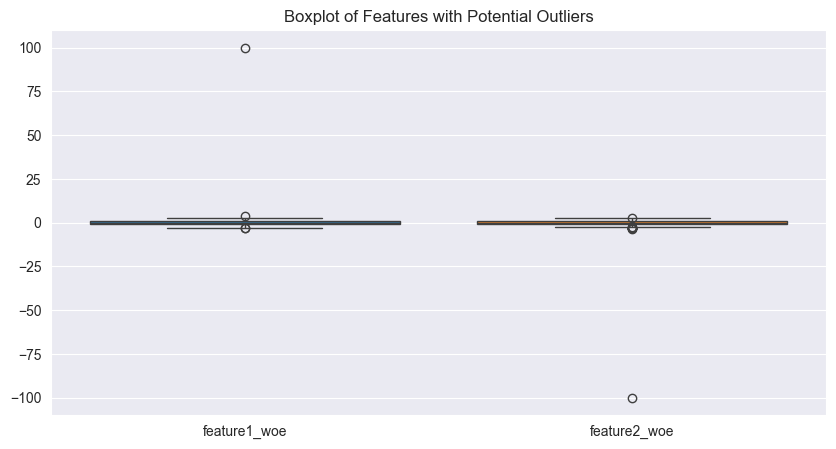

Logistic Regression Cross-validated accuracy: 0.5137 ± 0.0560
Accuracy: 0.4950
AUC: 0.5329
Confusion Matrix:
[[57 43]
 [58 42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       100
           1       0.49      0.42      0.45       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200

Accuracy with noise: 0.5550
AUC with noise: 0.5906
Accuracy with extreme values: 0.4950
AUC with extreme values: 0.5362


In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 示例数据集
data = pd.DataFrame({
    'feature1_woe': np.random.randn(1000),
    'feature2_woe': np.random.randn(1000),
    'default': np.random.randint(0, 2, 1000)
})

# 添加一些异常值
data.loc[0, 'feature1_woe'] = 100
data.loc[1, 'feature2_woe'] = -100

# 检查缺失值
print(data.isnull().sum())

# 检测异常值
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[['feature1_woe', 'feature2_woe']])
plt.title("Boxplot of Features with Potential Outliers")
plt.show()

# 分割数据集为训练集和测试集
X = data[['feature1_woe', 'feature2_woe']]
y = data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 对数据进行标准化处理
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 建立逻辑回归模型
model_LR = LogisticRegression(max_iter=10000, C=1.0, penalty='l2', solver='lbfgs')

# 使用交叉验证评估模型性能
cv_scores = cross_val_score(model_LR, X_train, y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-validated accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 在训练集上训练模型
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)
y_pred_proba = model_LR.predict_proba(X_test)[:, 1]

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 模型鲁棒性测试 - 添加噪声
X_test_noisy = X_test + np.random.normal(0, 1, X_test.shape)
y_pred_noisy = model_LR.predict(X_test_noisy)
y_pred_proba_noisy = model_LR.predict_proba(X_test_noisy)[:, 1]

# 评估噪声下的模型性能
accuracy_noisy = accuracy_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_pred_proba_noisy)
print(f"Accuracy with noise: {accuracy_noisy:.4f}")
print(f"AUC with noise: {auc_noisy:.4f}")

# 异常输入值测试
X_test_extreme = X_test.copy()
X_test_extreme[0, :] = [999, -999]
y_pred_extreme = model_LR.predict(X_test_extreme)
y_pred_proba_extreme = model_LR.predict_proba(X_test_extreme)[:, 1]

# 评估极端值下的模型性能
accuracy_extreme = accuracy_score(y_test, y_pred_extreme)
auc_extreme = roc_auc_score(y_test, y_pred_proba_extreme)
print(f"Accuracy with extreme values: {accuracy_extreme:.4f}")
print(f"AUC with extreme values: {auc_extreme:.4f}")
